In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn.apionly as sns
%matplotlib inline
sns.set_context("notebook")

In [2]:
path = "/Users/eesmalling/Data/project121/"
bns = pd.read_csv(path+"business_edit.csv").iloc[:,1:]
usr = pd.read_csv(path+"user_edit.csv").iloc[:,1:]
rvw = pd.read_csv(path+"review_edit.csv").iloc[:,1:]

## The Dataset
Yelp's academic dataset contains 5.79 gigabytes of data, consisting of restaurant review text, photos, and data on users and businesses. For the purposes of our project, we used three of the tables available:

+ Business: each row contains information about a single restaurant - name, number of times reviewed, average rating, and location.
+ User: each row contains information about a single user who has posted a review - name, number of reviews, the average star-rating provided by the user, types of compliments given, and number of times the user’s review was marked ‘Useful’.
+ Review: each row corresponds to a single review - date of review, name of the restaurant, user ID and the star rating provided in the review.

### Business
The business data table consists of 51613 restaurants. While Yelpers can write reviews of businesses around the globe, the dataset is limited to several distinct states and regions. Ontario, Canada makes up the largest share of restaurants, followed by Arizona and Nevada. While some of these states are adjacent to each other, the geographical area covered by the dataset is not continuous.

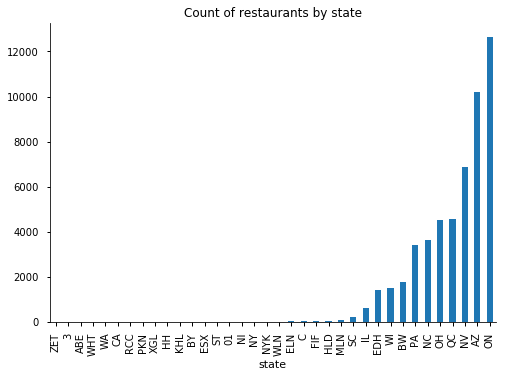

In [3]:
bns.groupby(['state']).size().sort_values().plot.bar()
plt.title('Count of restaurants by state')
sns.despine();

We also can see below the wide disparity in how many times a restaurant is reviewed. While several popular restaurants were reviewed thousands of times, a large portion of the dataset consists of restaurants only reviewed a couple of times.

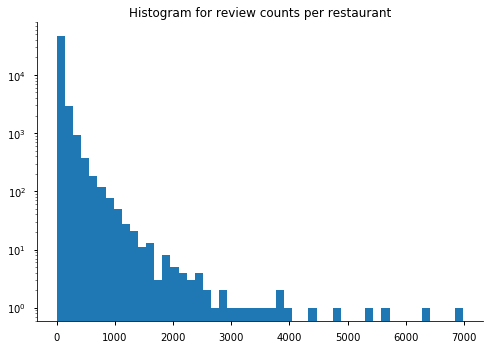

In [4]:
plt.hist(bns['review_count'], bins = 50)
plt.yscale('log')
plt.title('Histogram for review counts per restaurant')
sns.despine();

In [5]:
thresh = np.array([1,3,5,10,25,100,1000], dtype="int")
prop = [np.round(np.mean(bns.review_count<=i)*100,2) for i in thresh]
pd.DataFrame(dict(max_reviews = thresh, percent_total = prop)).transpose()

,0,1,2,3,4,5,6
max_reviews,1.0,3.00,5.00,10.00,25.00,100.00,1000.00
percent_total,0.0,7.94,19.25,36.05,59.02,86.35,99.69


### User
The user data table consists of 823317 unique users who have reviewed restaurants in the dataset. We see below that, with the exception of a few “power users” that write hundreds of reviews, most users only choose to review restaurants on occasion. For example, 60% of users wrote 10 or fewer reviews:

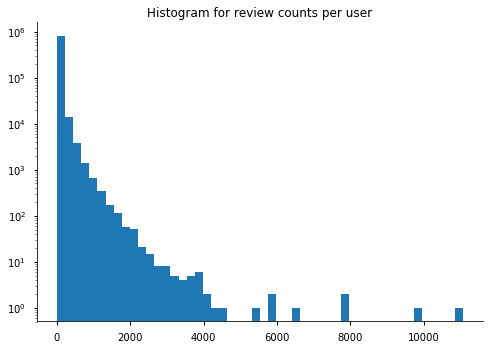

In [6]:
plt.hist(usr['review_count'], bins = 50)
plt.yscale('log')
plt.title('Histogram for review counts per user')
sns.despine();

In [7]:
thresh = [1,3,5,10,25,100,1000]
prop = [np.round(np.mean(usr.review_count<=i)*100,2) for i in thresh]
pd.DataFrame(dict(max_reviews = thresh, pct_total = prop)).transpose()

,0,1,2,3,4,5,6
max_reviews,1.00,3.00,5.00,10.00,25.00,100.00,1000.00
pct_total,12.74,31.71,44.01,60.65,78.97,93.69,99.87


### Review
Noting the discrete regions and low review counts per user and restaurant, we sensed that matrix sparsity would be a big challenge while using matrix factorization to build a review prediction model. In the context of this problem, a sparse matrix would occur when there is little overlap in the restaurants that individual users review, while a “perfectly full” matrix would occur if every user in the data set reviewed every restaurant in the dataset. In the table below, for a given region or combination of regions, we see the number of unique users and restaurants with reviews in that region. The total possible ratings is simply the product of the unique users and restaurants, and coverage is the proportion of these ratings that are actually in the dataset. Coverage, then serves as a measure of matrix sparsity, should we limit our analysis to that region.

In [8]:
cvg = rvw.merge(bns[['business_id','state']], how='left')
cvg_u = cvg.groupby('state')['user_id'].nunique().reset_index()
cvg_b = cvg.groupby('state')['business_id'].nunique().reset_index()
cvg_s = cvg.groupby('state')['stars'].count().reset_index()
cvg_all = pd.DataFrame(cvg_u).merge(pd.DataFrame(cvg_b), how='left').merge(pd.DataFrame(cvg_s), how='left')
cvg_all['mx_size'] = cvg_all.user_id*cvg_all.business_id
cvg_all['mx_coverage'] = round(cvg_all.stars/cvg_all.mx_size,6)
cvg_cols = cvg_all.columns
def state_mx(states, label):
    temp = cvg[cvg.state.isin(states)]
    row = pd.DataFrame(dict(state = label,
                            user_id = temp.user_id.nunique(),
                            business_id = temp.business_id.nunique(),
                            stars = len(temp)), index = np.ones(1))
    row['mx_size'] = row.user_id*row.business_id
    row['mx_coverage'] = row.stars/row.mx_size
    return row
cvg_all = cvg_all.append(state_mx(['IL','WI'], 'IL+WI'))
cvg_all = cvg_all.append(state_mx(['ON','QC'], 'ON+QC'))
cvg_all = cvg_all.append(state_mx(['AZ','NV'], 'AZ+NV'))
cvg_all = cvg_all.append(state_mx(['NC','SC'], 'NC+SC'))
cvg_all = cvg_all.append(state_mx(cvg.state.unique(), 'ALL STATES'))
cvg_all = cvg_all.sort_values('mx_coverage')[cvg_cols].reset_index().drop('index', axis=1)
cvg_all.columns = ['region','unique_users','unique_businesses','total_ratings','possible_ratings','coverage']

In [9]:
cvg_all

,region,unique_users,unique_businesses,total_ratings,possible_ratings,coverage
0,ALL STATES,823317,51613,2927731,42493860321,0.000069
1,AZ+NV,539224,17102,1787140,9221808848,0.000194
2,ON+QC,113331,17201,513411,1949406531,0.000263
3,AZ,232460,10219,837240,2375508740,0.000352
4,ON,85786,12634,414444,1083820324,0.000382
5,NV,326162,6883,949900,2244973046,0.000423
6,QC,32684,4567,98967,149267828,0.000663
7,OH,49062,4513,154764,221416806,0.000699
8,NC+SC,58213,3826,186600,222722938,0.000838
9,NC,56923,3625,180619,206345875,0.000875


We see that there is a tradeoff between the number of reviews and the sparsity of the matrix: the states at the bottom have full coverage but only a few reviews, while the states/regions at the top have many reviews but a relatively sparse matrix. We also note that matrices encompassing two or more states are necessarily more sparse than those for just one state, as it is rare that a user reviews restaurants in multiple states. In order to make sure that the matrix is not too sparse and to consider a large enough set of reviews, we chose to limit our analysis to Ontario and Quebec, Canada's two most populous provinces. The total number of restaurants in these two provinces make up roughly a third of the total number of restaurants in the dataset, while the resulting matrix would be significantly less sparse than using the entire dataset or the larger Arizona and Nevada region.